In [11]:
#imports
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import scipy as sp
import scipy.linalg as spl
import scipy.stats as sps

import pandas as pd

import matplotlib.pyplot as plt

import time

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from our_package import * #allows us to use our functions directly

## Set up parameters

In [5]:
#Lambda = 10
T = 30
#param_accept = 0.3
a = 1
b = 0

## Checking the behavior of $Y$ (mean of L2-norm part in distribution used for RW), $x_{true}$ (reproduction rate) and $x_{tilde,true}$ (second-derivative of reproduction rate) simulated with $\mathcal{E}(\lambda)$ law

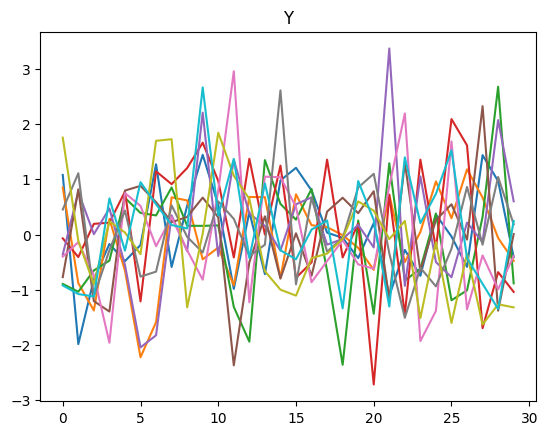

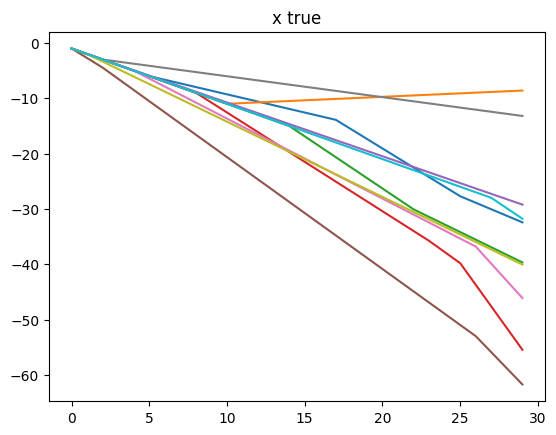

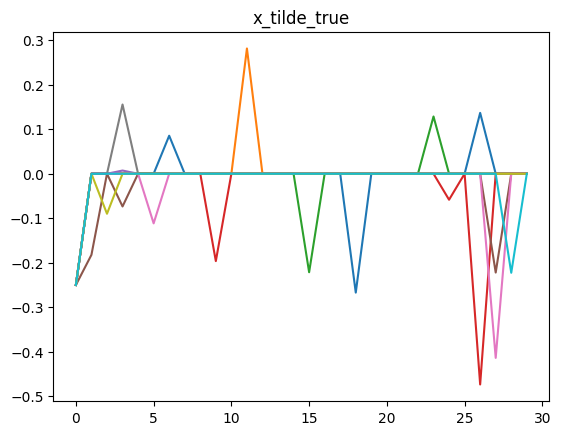

In [7]:
Lambda = 5
taille_echant = 10
Y = np.zeros((taille_echant, T))
x_true = np.zeros((taille_echant, T))
x_tilde_true = np.zeros((taille_echant, T))
for i in range(taille_echant):
    Y[i,:], x_true[i,:], x_tilde_true[i,:] = Computation_Y_simu_debug(T, Lambda,a,b)
    fig = plt.figure(1)
    plt.plot(Y[i,:])
    plt.title("Y")
    fig = plt.figure(2)
    plt.plot(x_true[i,:])
    plt.title("x true")
    fig = plt.figure(3)
    plt.plot(x_tilde_true[i,:])
    plt.title("x_tilde_true")
plt.show()

> We wanted our $x_{true}$ to have the shape of a hat to be the same kind of the real epidemiological data of Covid19 but with our simulations, we can see that it is almost never the case and that the value for some component of some simulations is exploding with the value  of $T$. So we forget this way of simulating $Y$ and we will just fix the value of  $x_{true}$ to get this hat shape and then transform it to get $Y$.

## Checking the behavior of $Y$ (mean of L2-norm part in distribution used for RW), $x_{true}$ (reproduction rate) and $x_{tilde,true}$ (second-derivative of reproduction rate) with deterministic $x_{true}$

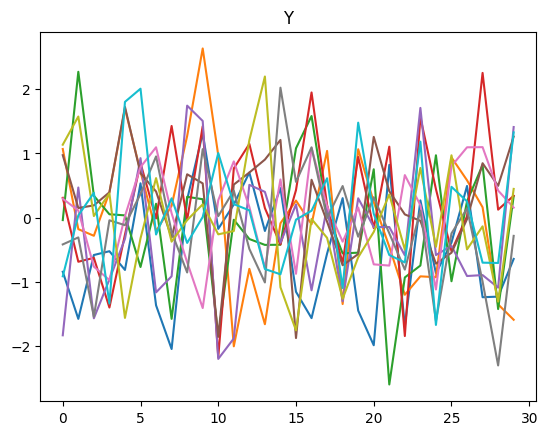

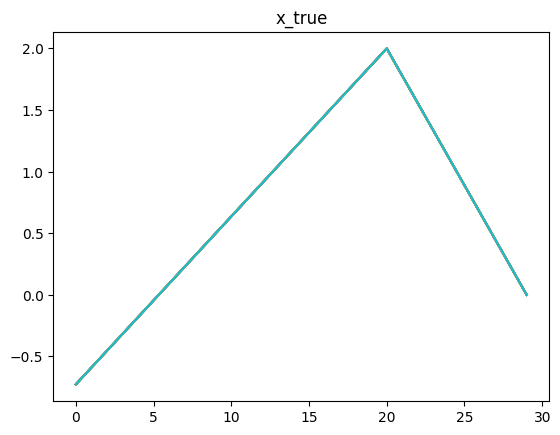

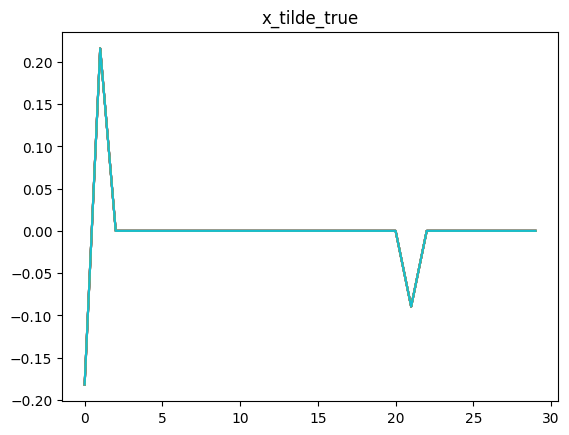

In [8]:
taille_echant = 10
Y = np.zeros((taille_echant, T))
x_true = np.zeros((taille_echant, T))
x_tilde_true = np.zeros((taille_echant, T))
for i in range(taille_echant):
    Y[i,:], x_true[i,:], x_tilde_true[i,:],_ = Computation_Y_circ_det_debug(T, 0.9)
    fig = plt.figure(1)
    plt.plot(Y[i,:])
    plt.title("Y")
    fig = plt.figure(2)
    plt.plot(x_true[i,:])
    plt.title("x_true")
    fig = plt.figure(3)
    plt.plot(x_tilde_true[i,:])
    plt.title("x_tilde_true")

plt.show()

## Choice of lambda

> We set lambda such that the value of the prior at x_true is equal to 0.99 (almost equal to the value of the prior at the argmax, which is 1). We remind that the prior is the L1 norm part of the distribution.

In [9]:
#Y = Computation_Y_exp(T, Lambda, a, b)
Y, Lambda, a, b = Computation_Y_circ_det(T, 0.99)
print(Lambda)

0.011040036055441254


## Theoretical results on the toy example (mean, argmax and quantiles)

In [12]:
### we call the different functions
#Lambdas = [100] + [0.5*i for i in range(100,1000,100)] + [750,1000]
#Y_simu=Create_DicoY(T,[Lambda],a,b)
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)
#Y ,Lambda= Computation_Y_circ_det(T)
x,x_tilde = ComputeArgmax(T,Lambda, Y,a,b)
mu,mu_tilde = ComputeMeans(T,Lambda, Y,a,b)
q1 = ComputeQuantiles(T,Lambda,0.975*np.ones(T), Y,a,b)
q2 = ComputeQuantiles(T,Lambda,0.025*np.ones(T), Y,a,b)
med = ComputeQuantiles(T,Lambda,0.5*np.ones(T), Y,a,b)
t2=time.time()

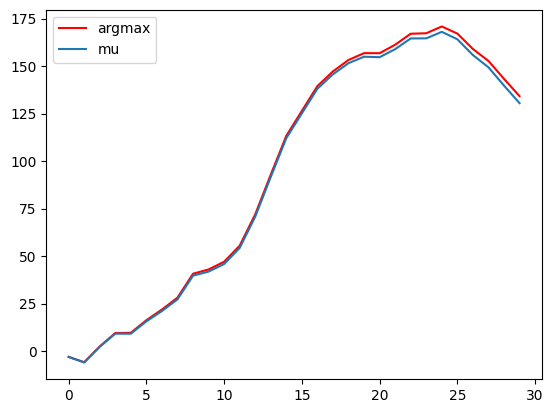

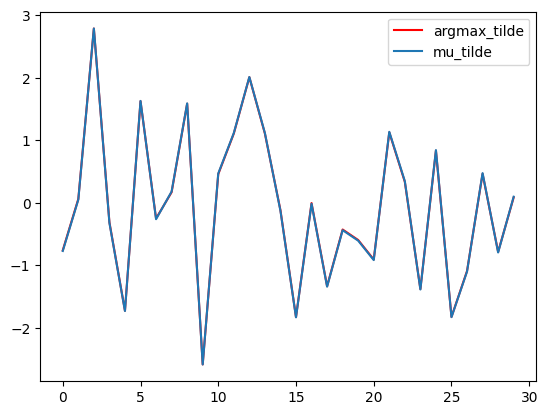

[-0.76360571  0.05764074  2.78412166 -0.31390775 -1.72970864  1.62129179
 -0.25457129  0.1657208   1.58150194 -2.58830722  0.45479871  1.10404009
  2.00575721  1.10394517 -0.12112562 -1.83103905 -0.0076672  -1.33789519
 -0.43070067 -0.59880843 -0.91022658  1.12392758  0.33124049 -1.38329396
  0.82979448 -1.82886085 -1.0947679   0.46095234 -0.78835583  0.08304384]


In [13]:
plt.figure()
plt.plot(x, color = "red", label= "argmax")
plt.plot(mu, label = "mu")
plt.legend()
plt.figure()
plt.plot(x_tilde, color = "red", label= "argmax_tilde")
plt.plot(mu_tilde, label = "mu_tilde")
plt.legend()
plt.show()
print(x_tilde)

## Simulation with the different methods

In [8]:
t1=time.time()
sim_theta1,sim_theta_tilde1,sim_accepts1,sim_gammas1, Mean1,end_source = MetropolisHastings(T,Lambda, Y, a,b,1e5, "source")
sim_theta2,sim_theta_tilde2,sim_accepts2,sim_gammas2, Mean2,end_image = MetropolisHastings(T,Lambda, Y, a,b,1e5, "image")
sim_theta3,sim_theta_tilde3,sim_accepts3,sim_gammas3, Mean3,end_subdiff_source = MetropolisHastings(T,Lambda, Y,a,b, 1e5, "subdiff_source")
sim_theta4,sim_theta_tilde4,sim_accepts4,sim_gammas4, Mean4,end_subdiff_image = MetropolisHastings(T,Lambda, Y, a,b,1e5, "subdiff_image")
t2=time.time()
print(t2-t1)

End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
446.990567445755


In [60]:
theta_tab_prox_image,theta_tab_prox_image_tilde,_,_,_,end_prox_image = MH_Prox_Image(T, Lambda, Y, a, b)

taux d'accept 0.945
gamma 0.0001
taux d'accept 0.957
gamma 0.00017050000000000002
taux d'accept 0.971
gamma 0.00029274850000000007
taux d'accept 0.971
gamma 0.0005067476535000001
taux d'accept 0.978
gamma 0.0008771801882085002
taux d'accept 0.982
gamma 0.0015245391671063733
taux d'accept 0.993
gamma 0.0026557472290993024
taux d'accept 0.992
gamma 0.004655524892611077
taux d'accept 0.991
gamma 0.008156479611854608
taux d'accept 0.995
gamma 0.014281995800357418
taux d'accept 0.996
gamma 0.025064902629627267
taux d'accept 0.996
gamma 0.044013969017625484
taux d'accept 1.0
gamma 0.07728852959495035
taux d'accept 1.0
gamma 0.13602781208711262
taux d'accept 0.999
gamma 0.2394089492733182
taux d'accept 1.0
gamma 0.4211203417717667
taux d'accept 0.999
gamma 0.7411718015183094
taux d'accept 0.998
gamma 1.3037211988707063
taux d'accept 0.015
gamma 2.2919418676147014
taux d'accept 0.996
gamma 1.7762549474013936
taux d'accept 0.005
gamma 3.119103687636847
taux d'accept 0.0
gamma 2.386114321042188


In [61]:
q = np.array([2.5,50,97.5])
quantiles_emp1 = Quantiles(sim_theta_tilde1, q,T)
quantiles_emp2 = Quantiles(sim_theta_tilde2, q,T)
quantiles_emp3 = Quantiles(sim_theta_tilde3, q,T)
quantiles_emp4 = Quantiles(sim_theta_tilde4, q,T)
quantiles_emp5 = Quantiles(theta_tab_prox_image_tilde, q,T)

## Visualisation of theory VS simulation

C:\Users\arman\AppData\Local\Temp\ipykernel_8856\55107099.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


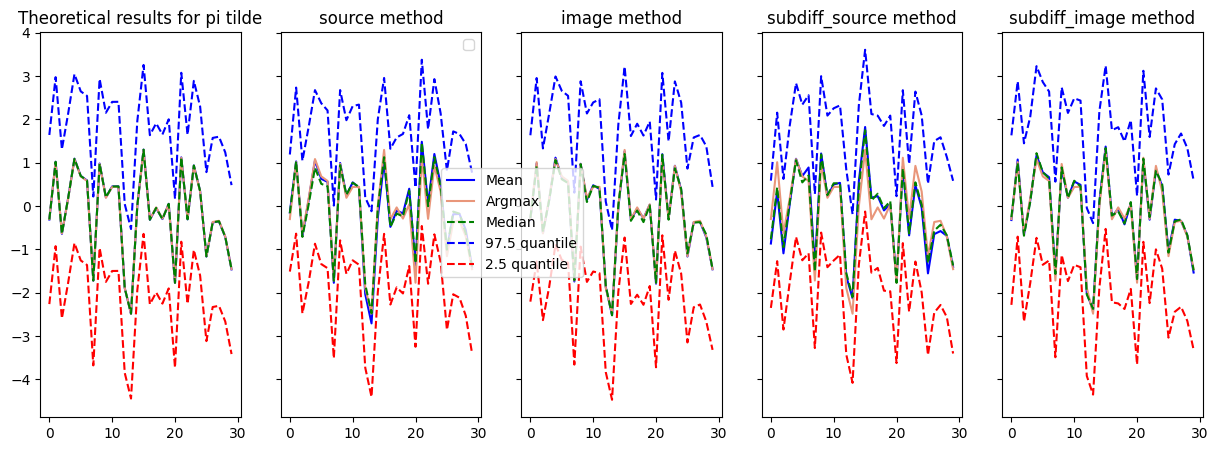

Qualité d'estimations des quantiles : 
Source :  0.3919789488893855
Image :  0.10308241243327504
Source Subdiff :  0.5811055027336856
Image Subdiff :  0.19676485770593544
Prox Image :  1.9613646779740992


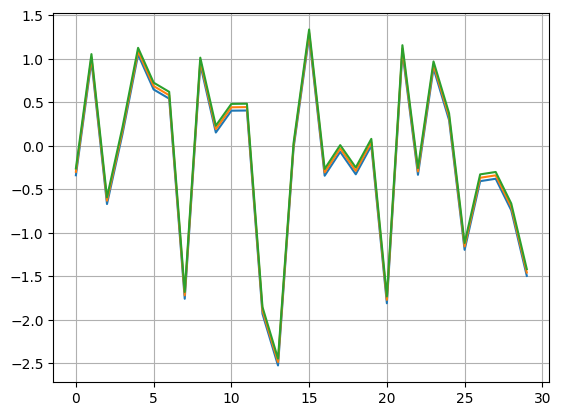

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), sharey=True)
#Plot of theoretical results
axes[0].plot(mu_tilde,color="blue",label="Mean")
axes[0].plot(x_tilde,color="darksalmon",label="Argmax")
axes[0].plot(med,'g--',label="Median")
axes[0].plot(q1,'b--',label="97.5 quantile")
axes[0].plot(q2,'r--',label="2.5 quantile")
axes[0].set_title("Theoretical results for pi tilde")


#Plot of empirical results
axes[1].plot(D@Mean,color="blue")
axes[1].plot(x_tilde,color="darksalmon")
axes[1].plot(quantiles_emp1[1],'g--')
axes[1].plot(quantiles_emp1[2],'b--')
axes[1].plot(quantiles_emp1[0],'r--')
axes[1].set_title("source method")
axes[1].legend()


#Plot of empirical results with method image
axes[2].plot(D@Mean2,color="blue")
axes[2].plot(x_tilde,color="darksalmon")
axes[2].plot(quantiles_emp2[1],'g--')
axes[2].plot(quantiles_emp2[2],'b--')
axes[2].plot(quantiles_emp2[0],'r--')
axes[2].set_title("image method")

#Plot of empirical results with method subdiff_source
axes[3].plot(D@Mean3,color="blue")
axes[3].plot(x_tilde,color="darksalmon")
axes[3].plot(quantiles_emp3[1],'g--')
axes[3].plot(quantiles_emp3[2],'b--')
axes[3].plot(quantiles_emp3[0],'r--')
axes[3].set_title("subdiff_source method")

#Plot of empirical results with method subdiff_image
axes[4].plot(D@Mean4,color="blue")
axes[4].plot(x_tilde,color="darksalmon")
axes[4].plot(quantiles_emp4[1],'g--')
axes[4].plot(quantiles_emp4[2],'b--')
axes[4].plot(quantiles_emp4[0],'r--')
axes[4].set_title("subdiff_image method")
# Shrink current axis by 20%
box0,box1 = axes[0].get_position(),axes[1].get_position()
axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
axes[1].set_position([box1.x0*0.8, box1.y0, box1.width * 0.8, box1.height])
fig.legend(loc=(0.8*box1.x0+box1.width,box1.height/2))
plt.show()

quantile_quality_source = np.sum(abs(quantiles_emp1[0] - q2))/(np.sum(abs(q2))) + np.sum(abs(quantiles_emp1[1] - med))/np.sum(abs(med)) + np.sum(abs(quantiles_emp1[2] - q1))/np.sum(abs(q1))
quantile_quality_image = np.sum(abs(quantiles_emp2[0] - q2))/np.sum(abs(q2)) + np.sum(abs(quantiles_emp2[1] - med))/np.sum(abs(med)) + np.sum(abs(quantiles_emp2[2] - q1))/np.sum(abs(q1))
quantile_quality_subdiff_source = np.sum(abs(quantiles_emp3[0] - q2))/np.sum(abs(q2)) + np.sum(abs(quantiles_emp3[1] - med))/np.sum(abs(med)) + np.sum(abs(quantiles_emp3[2] - q1))/np.sum(abs(q1))
quantile_quality_subdiff_image = np.sum(abs(quantiles_emp4[0] - q2))/np.sum(abs(q2)) + np.sum(abs(quantiles_emp4[1] - med))/np.sum(abs(med)) + np.sum(abs(quantiles_emp4[2] - q1))/np.sum(abs(q1))
quantile_quality_prox_image = np.sum(abs(quantiles_emp5[0] - q2))/np.sum(abs(q2)) + np.sum(abs(quantiles_emp5[1] - med))/np.sum(abs(med)) + np.sum(abs(quantiles_emp5[2] - q1))/np.sum(abs(q1))

print("Qualité d'estimations des quantiles : ")

print("Source : ", quantile_quality_source)
print("Image : ", quantile_quality_image)
print("Source Subdiff : ", quantile_quality_subdiff_source)
print("Image Subdiff : ", quantile_quality_subdiff_image)
print("Prox Image : ", quantile_quality_prox_image)

plt.figure()
plt.plot(quantiles_emp5[0])
plt.plot(quantiles_emp5[1])
plt.plot(quantiles_emp5[2])
plt.grid()

## Convergence of the empirical mean (five first dimensions, without burn-in)

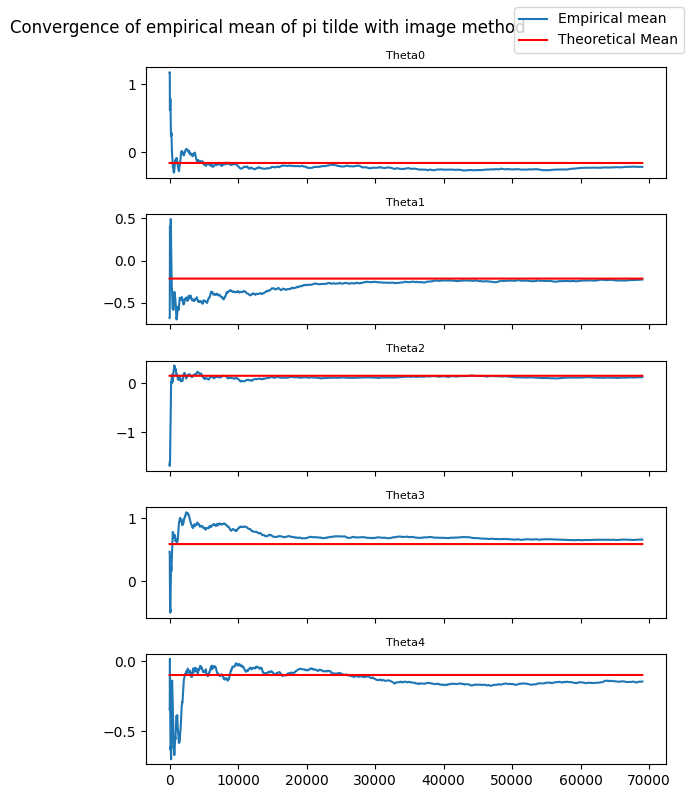

In [156]:
#Convergence plot of the mean of theta_tilde
nb_save=sim_theta2.shape[0] - end_image
x=np.linspace(1,nb_save,nb_save)
mean_tab=np.cumsum(sim_theta_tilde2[end_image:],axis=0)

fig,Axes = plt.subplots(5,1,figsize=(6,8),sharex=True)
for i in range(5):
    ax = Axes[i]
    res=mean_tab[:,i]/x
    ax.plot(x,res,label="Empirical mean" if i==0 else "")
    ax.plot(x,mu_tilde[i]*np.ones(nb_save),'r',label="Theoretical Mean" if i==0 else "")
    #ax.axvline(end_image,color="green")
    ax.set_title(f"Theta{i}",fontsize=8)

fig.suptitle("Convergence of empirical mean of pi tilde with image method", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

## Convergence of the acceptance rate (only burn-in phase)

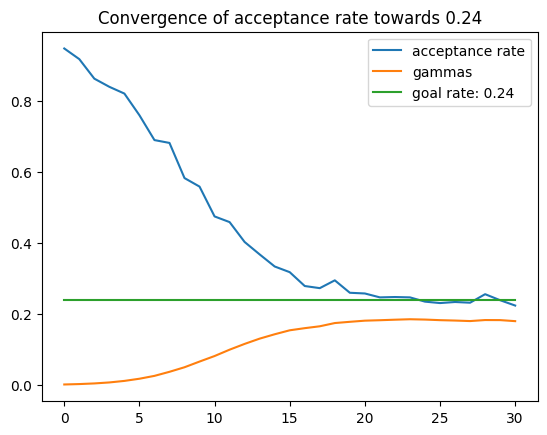

In [24]:
#print(sim_accepts2)
#print(end_image)
#print(len(sim_gammas2))
plt.plot(sim_accepts2[:int(end_image/1000)],label="acceptance rate")
plt.plot(sim_gammas2[:int(end_image/1000)],label="gammas")
plt.plot(np.ones(len(sim_accepts2[:int(end_image/1000)]))*0.24,label="goal rate: 0.24")
plt.title("Convergence of acceptance rate towards 0.24")
plt.legend()
plt.show()

## Impact of Lambda
In this part of the notebook, we will estimate $\theta$ tilde under different $\lambda \in \Lambda$. We define a list containing different $\lambda$ and we will create a DataFrame that computes the relative error for every component of $\theta$ several times, and we will look at the mean and standard deviation of the relative error for every component.

In [8]:
# TRES LONG, NE PAS REEXECUTER !

Lambdas = [0.1,0.5,1,5,10,50,100,500,1000]
#np.arange(0.5,5,0.5)#[0.1,0.5,0.8,1,1.3,1.6,2,4,7,9]
nb_sim = 5
method = "source"
n = len(Lambdas)
sim_theta_tildes = np.zeros((T,nb_sim,n))
Y_simu=Create_DicoY(T,Lambdas,a,b)

for k in range(n):
    Y = Y_simu[Lambdas[k]]
    for j in range(nb_sim):
        _, sim_theta_tildes[:,j,k] = MetropolisHastingsFast(T, Lambdas[k], Y,a,b,method=method)
        #print("working...")
    print(f"Oooh yeah! Finished {k+1}. iteration")

End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 1. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 2. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 3. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 4. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 5. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 6. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah! Finished 7. iteration
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in
Oooh yeah

In [9]:
print(pd.DataFrame(sim_theta_tildes[:,:,-1]))

           0         1         2         3         4
0   1.996454  2.006933  1.952585  1.949890  1.997437
1  -1.511638 -1.533125 -1.480410 -1.431917 -1.550888
2  -0.472964 -0.459456 -0.429158 -0.503867 -0.424420
3  -0.005204 -0.006882 -0.026731 -0.005184 -0.010705
4  -0.002334 -0.002548 -0.010045 -0.002715 -0.005440
5  -0.002098 -0.001614 -0.002573 -0.001791 -0.001926
6  -0.001436 -0.001559 -0.001534 -0.001310 -0.000670
7  -0.000817 -0.001375 -0.000957 -0.001207 -0.000306
8  -0.000645 -0.000734 -0.000462 -0.000891 -0.000169
9  -0.000556 -0.000496 -0.000230 -0.000805 -0.000043
10 -0.000315 -0.000260  0.000014 -0.000589 -0.000043
11 -0.000224 -0.000214  0.000127 -0.000401 -0.000124
12 -0.000230 -0.000043  0.000117 -0.000231 -0.000410
13 -0.000302  0.000238  0.000017  0.000107 -0.000497
14 -0.000089  0.000433  0.000002  0.000265 -0.000557
15  0.000222  0.000369 -0.000166  0.000265 -0.000977
16  0.000499  0.000351 -0.000184  0.000261 -0.000937
17  0.000795  0.000446 -0.000113  0.000182 -0.

The simulated $\theta$ sometimes takes tiny values close to 0, although the theoretical value is a bigger real number. This means that the relative error can exaggerate the magnitude of the error, since we divide by a small number. Therefore we opt for the following error:
$d(x,y) = \frac{|x-y|}{max(|x|,|y|}$

In [10]:
def dist(x,y):
    return np.abs(x-y)/np.maximum(np.abs(x),np.abs(y))

In [11]:
"""
a = np.array([1,2,3,4])
b = np.array([3,4,8,9])
dist(a,b)
"""

array([0.66666667, 0.5       , 0.625     , 0.55555556])

In [17]:
errors = np.zeros(np.shape(sim_theta_tildes))
for k in range(n):
    Y = Y_simu[Lambdas[k]]
    _, theoretical_means = ComputeMeans(T, Lambdas[k], Y, a, b)
    errors[:,:,k] = dist(sim_theta_tildes[:,:,k],theoretical_means[:,np.newaxis] @ np.ones((1,nb_sim)))
    #errors[:,:,k] = abs(sim_theta_tildes[:,:,k] - theoretical_means[:,np.newaxis] @ np.ones((1,10))) / np.max(np.abs(sim_theta_tildes[:,:,k])

C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:112: RuntimeWarning: divide by zero encountered in divide
  mu_tilde_minus = mu_minus + np.exp(-((sh+mu_minus)**2)/2) / (np.sqrt(2*np.pi)*C_minus)
C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:113: RuntimeWarning: invalid value encountered in multiply
  mu_tilde = gamma*mu_tilde_plus + (1-gamma)*mu_tilde_minus
C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:110: RuntimeWarning: invalid value encountered in divide
  gamma = C_plus / (C_plus + C_minus)
C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:111: RuntimeWarning: invalid value encountered in divide
  mu_tilde_plus = mu_plus - np.exp(-((sh+mu_plus)**2)/2) / (np.sqrt(2*np.pi)*C_plus)
C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:112: RuntimeWarning: invalid value encountered in divide
  mu_tilde_minus = mu_minus + np.exp(-((sh+mu_minus)**2)/2) / (np.sqrt(2*np

In [18]:
print(np.shape(errors))
data = np.zeros((T,2*n))
for i in range(n//2+1):
    data[:,2*i] = np.mean(errors[:,:,i],axis=1)
    data[:,2*i+1]=np.std(errors[:,:,i],axis=1)
assert np.shape(data)==(T,2*n)
df = pd.DataFrame(data)

df.columns = pd.MultiIndex.from_product([Lambdas,["mean","std"]],names=["lambdas","measure"])
df

(30, 5, 9)


lambdas      0.1                 0.5                 1.0                 1.5   \
measure      mean       std      mean       std      mean       std      mean   
0        0.186063  0.131679  0.267960  0.087931  0.110732  0.078916  0.099946   
1        0.242283  0.107338  0.126232  0.110820  0.511077  0.109267  0.801089   
2        0.067584  0.038183  0.213459  0.081709  0.512064  0.091854  0.422916   
3        0.074317  0.042858  0.266013  0.064510  0.170713  0.041457  0.631664   
4        0.053554  0.013752  0.374384  0.081423  0.485618  0.053414  0.379139   

lambdas                2.0             ... 3.5       4.0       4.5       7.5   \
measure       std      mean       std  ... mean  std mean  std mean  std mean   
0        0.063626  0.116557  0.049094  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.274570  0.290224  0.028115  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.056652  0.495572  0.045019  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.041812  0.177827  0.028931  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.015545  0.045347  0.005999  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

lambdas      10.0       
measure  std mean  std  
0        0.0  0.0  0.0  
1        0.0  0.0  0.0  
2        0.0  0.0  0.0  
3        0.0  0.0  0.0  
4        0.0  0.0  0.0  

[5 rows x 24 columns]

In [19]:
errors[:,:,-1]

lambdas    0.1                 0.5                 1.0                 5.0     \
measure      mean       std      mean       std      mean       std      mean   
0        0.145867  0.106746  0.283387  0.118020  0.552256  0.248125  0.269777   
1        0.377939  0.124596  1.322536  0.361262  0.296309  0.217450  0.169602   
2        0.651569  0.035358  0.600619  0.110322  0.243539  0.169287  0.714309   
3        0.887387  0.250337  0.175968  0.095212  0.844967  0.303703  0.673636   
4        0.325222  0.121628  0.133845  0.057946  0.636619  0.178401  0.965700   
5        1.006087  0.277040  1.094412  0.229036  0.406244  0.130191  0.670426   
6        0.079927  0.017596  0.361863  0.090134  0.266756  0.174842  0.740134   
7        0.287726  0.059982  0.637888  0.197702  0.272088  0.162498  1.056788   
8        0.708582  0.249505  0.600779  0.289485  0.505619  0.501360  0.501650   
9        0.151805  0.085430  0.404113  0.188600  0.282344  0.216958  0.899403   
10       0.123129  0.030712  0.203299  0.093220  0.698281  0.451157  0.296245   
11       0.456497  0.118181  0.543173  0.254302  0.294051  0.163728  0.850611   
12       0.135508  0.088974  0.445548  0.217892  0.341084  0.199530  0.729376   
13       0.119539  0.052910  0.263728  0.128049  0.242755  0.135736  0.877250   
14       0.180892  0.126045  0.206367  0.166600  0.133178  0.095023  0.766197   
15       0.234625  0.110735  0.318793  0.162323  0.218972  0.099765  0.791035   
16       0.094523  0.060204  0.491281  0.120441  0.549713  0.089079  0.962979   
17       0.227664  0.143855  0.593805  0.135470  0.692127  0.317107  1.063296   
18       0.271047  0.145977  0.282280  0.156312  1.243131  0.466269  0.481047   
19       1.021635  0.188788  1.110257  0.057562  1.251029  0.554654  1.351755   
20       0.224478  0.087455  0.096593  0.056023  0.259304  0.130594  0.472669   
21       0.301967  0.145680  1.156737  0.139023  0.695234  0.437707  0.607361   
22       0.606258  0.393487  0.206365  0.079903  1.055354  0.579181  0.702498   
23       0.501146  0.488588  1.334473  0.524635  0.727006  0.579939  0.684861   
24       0.683400  0.322014  1.467062  0.662112  1.394302  0.534449  0.537892   
25       0.724390  0.624666  0.474469  0.177898  0.570744  0.292792  0.920620   
26       0.662622  0.653419  0.122314  0.042186  0.479348  0.536939  0.722462   
27       0.615545  0.554409  0.269139  0.110865  0.589721  0.508428  0.851365   
28       0.566786  0.167912  0.177589  0.074072  0.533261  0.443233  0.823520   
29       0.010722  0.006472  0.304559  0.110045  0.284173  0.045353  1.048935   

lambdas              10.0             50.0        100.0       500.0        \
measure       std      mean       std   mean  std   mean  std   mean  std   
0        0.057417       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
1        0.071746       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
2        0.231536       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
3        0.129756       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
4        0.128459       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
5        0.117809       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
6        0.159376       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
7        0.312319       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
8        0.161870       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
9        0.188007       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
10       0.121361  0.979729  0.033444    0.0  0.0    0.0  0.0    0.0  0.0   
11       0.093963       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
12       0.167078       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
13       0.152797       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
14       0.156458  0.943731  0.228069    0.0  0.0    0.0  0.0    0.0  0.0   
15       0.228628       NaN       NaN    0.0  0.0    0.0  0.0    0.0  0.0   
16       0.207200    

In [20]:
df_mean = df.mean()


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\arman\AppData\Local\Temp\ipykernel_14468\803777224.py:5: SyntaxWarning: invalid escape sequence '\l'
  fig.suptitle(f"Error as function of $\lambda$, @{niter:} iterations, using method: {method}")


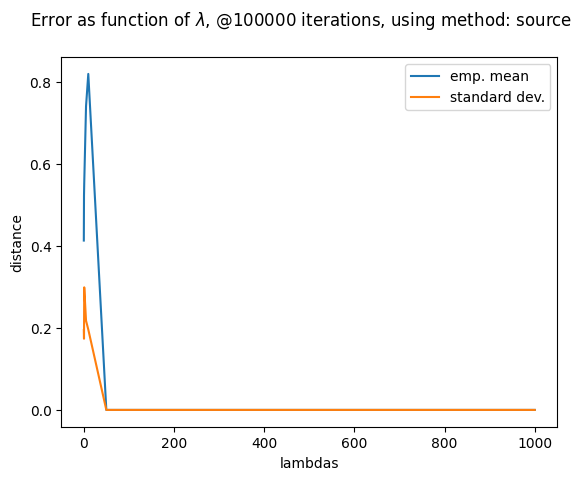

In [23]:
"""
niter = 10**5
fig,ax = plt.subplots(1,1)
df_mean.xs("mean", level=1, axis=0).plot(label="emp. mean")
df_mean.xs("std",  level=1, axis=0).plot(label="standard dev.")
fig.suptitle(f"Error as function of $\lambda$, @{niter:} iterations, using method: {method}")
ax.set_ylabel("distance")
ax.legend()
plt.grid()
"""

Pour lambda > 10, le calcul de la moyenne théorique ne fonctionne pas (divisions par zéro, on demande un degré de précision dans l'estimation de la loi normale N(0,1) qui est trop important). Il faudrait robustifier le code.

## Comparison of the empirical Log-Pi Distribution to the argmax

In [157]:
print(T)
print(a)
print(b)

End of the burn-in


C:\Users\arman\AppData\Local\Temp\ipykernel_4036\2519569021.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


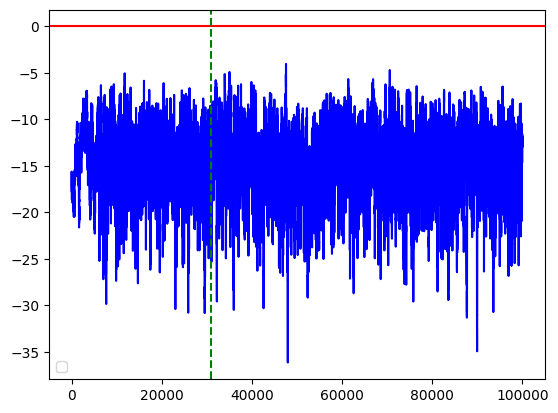

In [27]:
plt.figure()
#Y = Y_simu[Lambda]
#Y,Lambda=Computation_Y_circ(T,a,b)
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)
theta_tab, theta_tilde_tab, accepts, gammas, theta_mean,end_image = MetropolisHastings(T, Lambda, Y, a,b,method = "image")
plt.plot(LogDistributionPi_Tab(theta_tab, Y, A, D, sh, Lambda), color = "blue")
plt.axhline(LogDistributionPi(ComputeArgmax(T, Lambda, Y,a,b)[0], Y, A, D, sh, Lambda), color = "red")
plt.axvline(end_image,color="green",linestyle="--")
plt.legend()
plt.show()

The LogPi Distibution of the chain is always lower than the LogPi of the Argmax (as it is the maximum value). When T gets higher, the LogPi distribution gets lower compared to the argmax, it is understandable if we visualize the distribution as a product (even though it is not an independence case here).

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\arman\AppData\Local\Temp\ipykernel_4036\2292648833.py:14: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle("Accuracy of simulation and argmax for $\pi$ distribution", x=0.3)
C:\Users\arman\AppData\Local\Temp\ipykernel_4036\2292648833.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


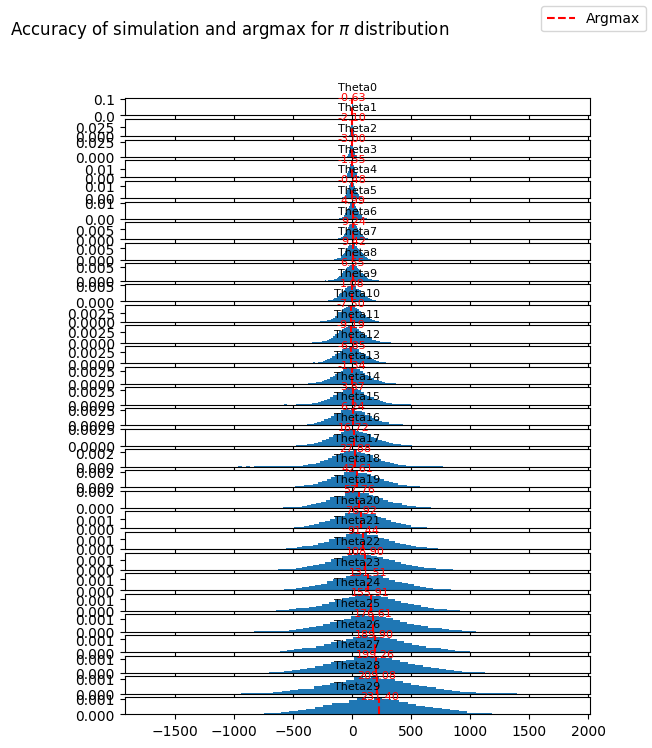

In [158]:
fig, axes = plt.subplots(nrows=T, ncols=1, figsize=(6, 8), sharex=True)
nb_save=theta_tab.shape[0]
argmax=ComputeArgmax(T, Lambda, Y, a, b)[0]
for i in range(T):
    ax = axes[i]
    ax.hist(theta_tab[:,i],bins=50,density=True)
    ax.plot(argmax[i],0,color='red')
    ax.axvline(argmax[i], color='red', linestyle='dashed', label="Argmax" if i==0 else "")
    ax.text(argmax[i], ax.get_ylim()[1] * 0.9, f"{argmax[i]:.2f}", 
            color='red', fontsize=8, ha='center')
    ax.set_title(f"Theta{i}",fontsize=8)


fig.suptitle("Accuracy of simulation and argmax for $\pi$ distribution", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

We can see that for the first components, the distibution of the simulation is quite well gaussian and we find quite well the argmax but as we increase the dimensions, this becomes less and less accurate, the distribution variance increases very fast and the distribution of the simulation seems to diverge to the real one as the argmax is not anymore equal to the graphic one.

We see that for further dimensions, the argmax takes lower values so if we take a uniform (0, ..., 0) starting point, it takes more time for the chain to reach its argmax, as the distribution function is really flat. (Arman's hypothesis)

C:\Users\arman\AppData\Local\Temp\ipykernel_4036\220238300.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


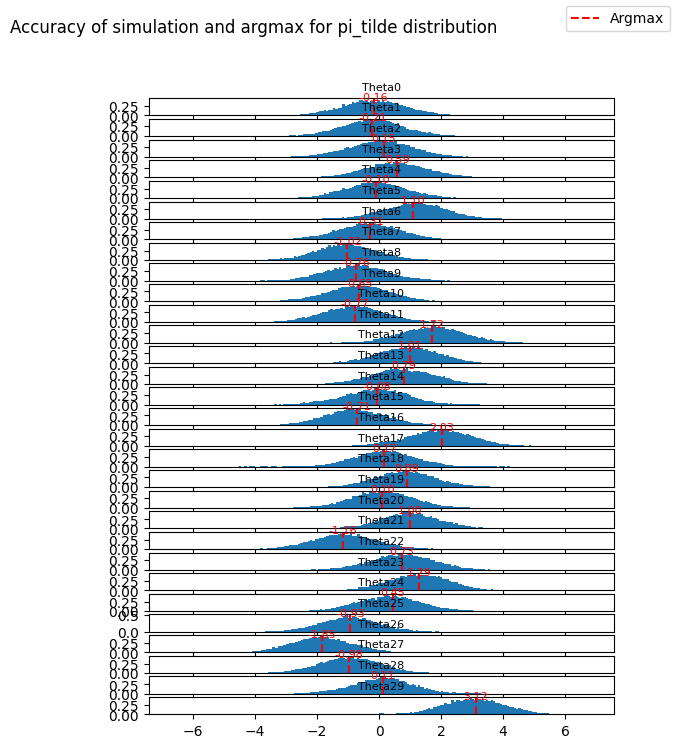

In [159]:
fig, axes = plt.subplots(nrows=T, ncols=1, figsize=(6, 8), sharex=True)
nb_save=theta_tab.shape[0]
argmax=ComputeArgmax(T, Lambda, Y, a, b)[1]
for i in range(T):
    ax = axes[i]
    ax.hist(theta_tilde_tab[:,i],bins=100,density=True)
    ax.plot(argmax[i],0,color='red')
    ax.axvline(argmax[i], color='red', linestyle='dashed', label="Argmax" if i==0 else "")
    ax.text(argmax[i], ax.get_ylim()[1] * 0.9, f"{argmax[i]:.2f}", 
            color='red', fontsize=8, ha='center')
    ax.set_title(f"Theta{i}",fontsize=8)


fig.suptitle("Accuracy of simulation and argmax for $\tilde\pi$ distribution", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

The result is better for the $\tilde\pi$ distribution, the symmetry and variance stay quite the same for every component and the graphic argmax is in accordance with the theoretical one.

In [84]:
T = 30
Lambdas = [1] + [5*i for i in range(1,5)] + [50,100]
Y_simu=Create_DicoY(T,Lambdas, a, b)
n_simu = len(Lambdas)
theoretical_means = np.zeros((n_simu, T))
errors_source = np.zeros(n_simu)
errors_image = np.zeros(n_simu)
errors_subdiff_source = np.zeros(n_simu)
errors_subdiff_image = np.zeros(n_simu)
errors_prox_image = np.zeros(n_simu)

for i in range(n_simu):
    #print(ComputeMeans(T, 1, Y_simu[Lambdas[i]])[0])
    theoretical_means[i,:] = ComputeMeans(T, 1, Y_simu[Lambdas[i]], a, b)[0]
    #print("done1")
    errors_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], a, b, method="source")[0]-theoretical_means[i,:]))
    #print(errors_source[i])
    errors_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], a, b, method="image")[0]-theoretical_means[i,:]))
    #print(errors_image[i])
    errors_subdiff_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], a, b, method="subdiff_source")[0]-theoretical_means[i,:]))
    #print(errors_subdiff_source[i])
    errors_subdiff_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], a, b, method="subdiff_image")[0]-theoretical_means[i,:]))
    #print(errors_subdiff_image[i])
    errors_prox_image[i] = sum(abs(MH_Prox_Image(T, 1, Y_simu[Lambdas[i]], a, b)[0][-1]-theoretical_means[i,:]))
    print("---Done---")

plt.figure()
plt.plot(errors_source, color = "blue")
plt.plot(errors_image, color = "green")
plt.plot(errors_subdiff_source, color = "red")
plt.plot(errors_subdiff_image, color = "black")
plt.plot(errors_prox_image, color = "yellow")
plt.show()

NameError: name 'Computation_Y' is not defined

Comparaison pour plusieurs valeurs de Lambda, erreur en norme 1 entre les moyennes empiriques et les moyennes théoriques pour différentes méthodes. Les moyennes empiriques sont obtenues après 10^5 itérations, une fois burn-in fini. 

### Différence entre les valeurs simulés et l'argmax en norme 2 (Comparaison à lambda fixé)

In [160]:
#Lambda=10
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T,a,b)
#Y = Computation_Y(T,Lambda,a,b)
#Y ,Lambda= Computation_Y_circ(T,a,b)
theta_tab_source,_,_,_,_,end_source = MetropolisHastings(T, Lambda, Y,a,b, 1e5, "source")
theta_tab_image,_,_,_,_,end_image = MetropolisHastings(T, Lambda, Y, a,b, 1e5,"image")
theta_tab_subdiff_source,_,_,_,_,end_subdiff_source = MetropolisHastings(T, Lambda, Y, a, b, 1e5, "subdiff_source")
theta_tab_subdiff_image,_,_,_,_,end_subdiff_image = MetropolisHastings(T, Lambda, Y, a,b, 1e5,"subdiff_image")

End of the burn-in
End of the burn-in
End of the burn-in
End of the burn-in


In [161]:
#print(Lambda)
argmax=ComputeArgmax(T, Lambda, Y,a,b)[0]

#dist_tab_source=np.sum(abs(theta_tab_source-argmax),axis=1)/sum(abs(argmax))
#dist_tab_image=np.sum(abs(theta_tab_image-argmax),axis=1)/sum(abs(argmax))
#dist_tab_subdiff_source=np.sum(abs(theta_tab_subdiff_source-argmax),axis=1)/sum(abs(argmax))
#dist_tab_subdiff_image=np.sum(abs(theta_tab_subdiff_image-argmax),axis=1)/sum(abs(argmax))

dist_tab_source=np.linalg.norm(theta_tab_source-argmax,axis=1)/np.linalg.norm(argmax)
dist_tab_image=np.linalg.norm(theta_tab_image-argmax,axis=1)/np.linalg.norm(argmax)
dist_tab_subdiff_source=np.linalg.norm(theta_tab_subdiff_source-argmax,axis=1)/np.linalg.norm(argmax)
dist_tab_subdiff_image=np.linalg.norm(theta_tab_subdiff_image-argmax,axis=1)/np.linalg.norm(argmax)

In [162]:
theta_tab_prox_image,_,_,_,_,end_prox_image = MH_Prox_Image(T, Lambda, Y, a, b)

End of the burn-in


In [51]:
theta_tab_prox_image

array([[   4.        ,   12.        ,   24.        , ..., 1624.        ,
        1740.        , 1860.        ],
       [   3.50075372,   10.75459365,   21.62919389, ..., 1473.46307498,
        1578.80534828, 1687.7725398 ],
       [   3.24584975,    9.82912055,   19.511781  , ..., 1326.11814973,
        1420.16355598, 1517.54116752],
       ...,
       [   3.02652616,    4.12477191,    5.26960708, ...,   29.97540064,
          30.53611709,   31.03553227],
       [   2.8342106 ,    3.70147826,    4.4775283 , ...,    6.76719981,
           6.31160067,    5.82358614],
       [   3.17295824,    4.33291575,    5.39130139, ...,   48.32676762,
          50.42916606,   52.62940725]])

[ -0.62632947  -2.10418779  -2.99850501  -1.54822453  -0.48432335
   4.990582     9.24472697   9.41533996   6.55428119   1.07822209
  -7.49534292  -9.1932815   -6.85181119  -1.33850285   3.87072995
   6.24152688  16.72184615  27.88002572  42.61173484  57.76171543
  76.91631936  91.43941412 108.89524927 131.50930483 155.91450275
 176.6099295  189.89521942 199.26413066 209.08360101 231.39699663]


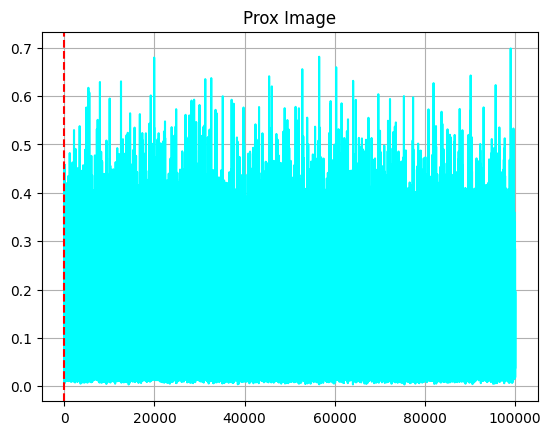

In [166]:
argmax=ComputeArgmax(T, Lambda, Y,a,b)[0]
print(argmax)
dist_tab_prox_image=np.linalg.norm(theta_tab_prox_image-argmax,axis=1)/np.linalg.norm(argmax)
plt.figure()
plt.title("Prox Image")
#plt.plot(np.mean(theta_tab_prox_image,axis=1))
plt.plot(dist_tab_prox_image[10:], color = "cyan")
plt.axvline(end_prox_image,color="red",linestyle="--")
plt.grid()

[ -0.62632947  -2.10418779  -2.99850501  -1.54822453  -0.48432335
   4.990582     9.24472697   9.41533996   6.55428119   1.07822209
  -7.49534292  -9.1932815   -6.85181119  -1.33850285   3.87072995
   6.24152688  16.72184615  27.88002572  42.61173484  57.76171543
  76.91631936  91.43941412 108.89524927 131.50930483 155.91450275
 176.6099295  189.89521942 199.26413066 209.08360101 231.39699663]


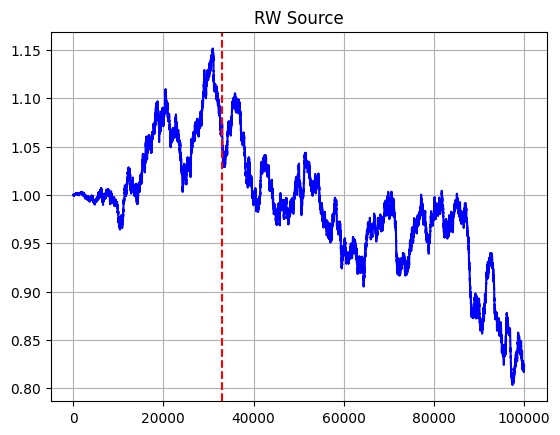

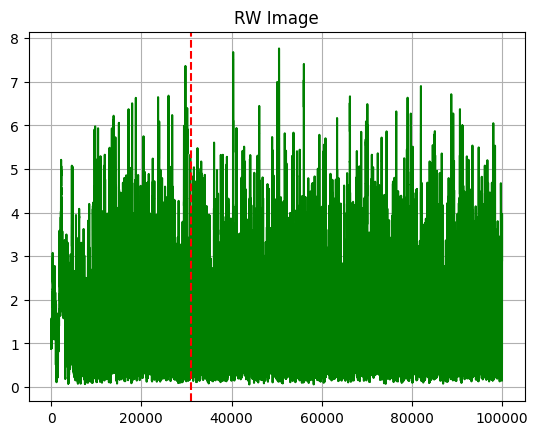

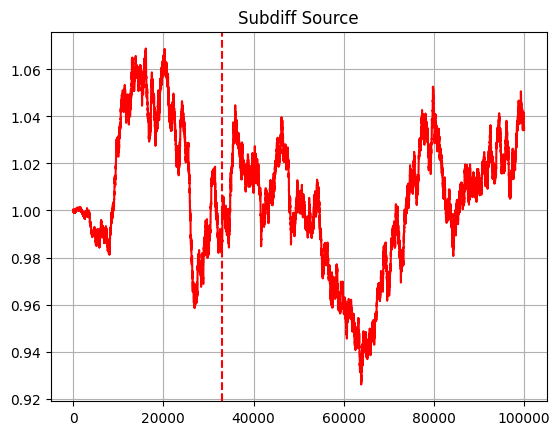

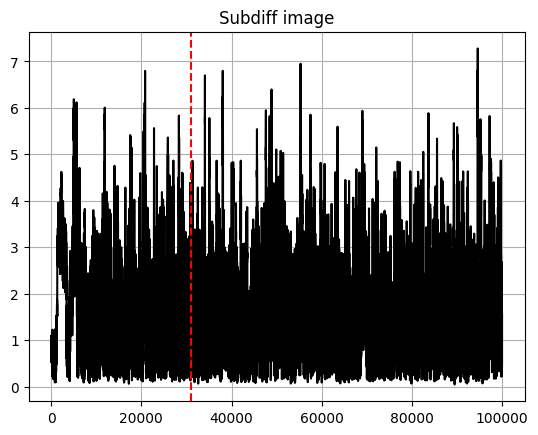

In [165]:
plt.figure()
plt.plot(dist_tab_source, color = "blue")
plt.axvline(end_source,color="red",linestyle="--")
plt.title("RW Source")
plt.grid()
plt.figure()
plt.title("RW Image")
plt.plot(dist_tab_image, color = "green")
plt.axvline(end_image,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff Source")
plt.plot(dist_tab_subdiff_source, color = "red")
plt.axvline(end_subdiff_source,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff image")
plt.plot(dist_tab_subdiff_image, color = "black")
plt.axvline(end_subdiff_image,color="red",linestyle="--")
plt.grid()
print(argmax)


> On voit que les méthodes sources ont vraiment du mal à converger vers l'argmax alors que les méthodes images convergent très rapidement pour ensuite osciller autour.

### Différence entre les valeurs simulés et l'argmax évaluées en `LogDistributionPi` en erreur relative (Comparaison à lambda fixé)

In [167]:
logpi_argmax=LogDistributionPi(argmax, Y, A, D, sh, Lambda)

dist_source = abs(LogDistributionPi_Tab(theta_tab_source, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)
dist_image = abs(LogDistributionPi_Tab(theta_tab_image, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)
dist_subdiff_source = abs(LogDistributionPi_Tab(theta_tab_subdiff_source, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)
dist_subdiff_image = abs(LogDistributionPi_Tab(theta_tab_subdiff_image, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)

-0.027520553564207753


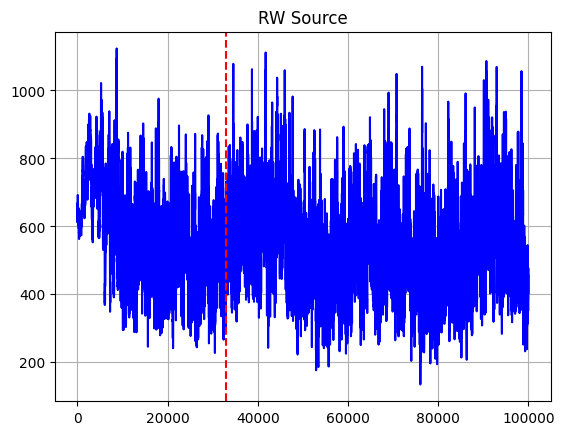

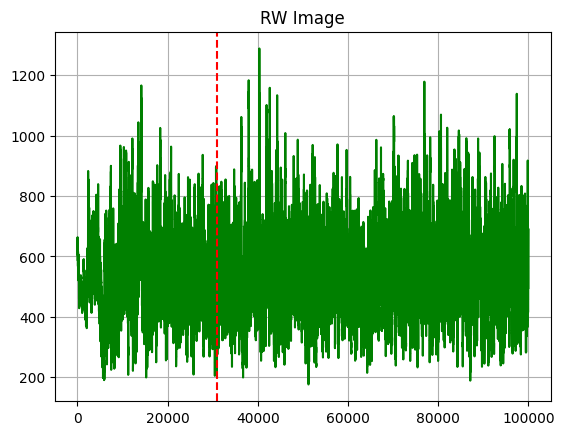

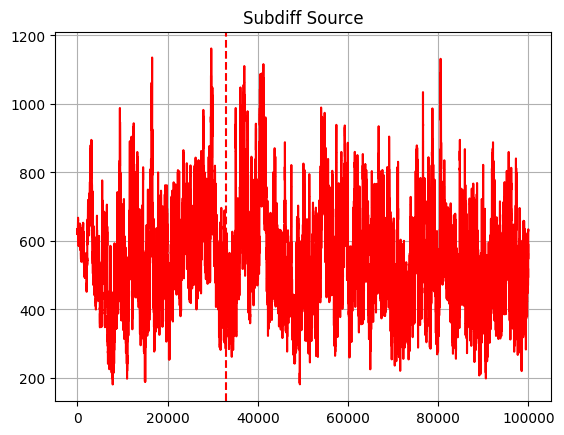

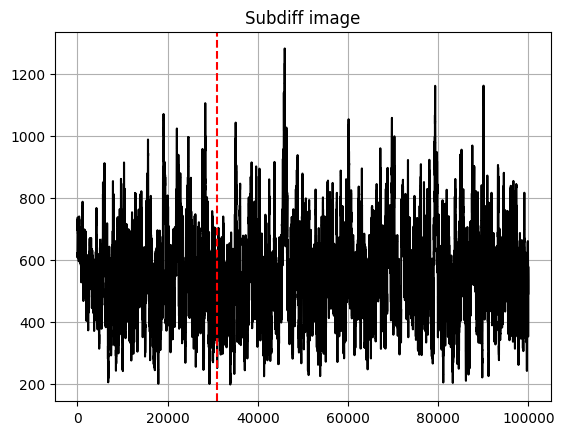

In [168]:
plt.figure()
plt.title("RW Source")
plt.plot(dist_source, color = "blue")
plt.axvline(end_source,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("RW Image")
plt.plot(dist_image, color = "green")
plt.axvline(end_image,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff Source")
plt.plot(dist_subdiff_source, color = "red")
plt.axvline(end_subdiff_source,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff image")
plt.plot(dist_subdiff_image, color = "black")
plt.axvline(end_subdiff_image,color="red",linestyle="--")
plt.grid()
print(logpi_argmax)

>We can see that the method in the image space converge much faster than the source method. Nevertheless, we don't see a significant improvement using the sub differential in the image space compare to the identity.